In [1]:
import os
import sys
import datetime
import random
import numpy as np
import pandas as pd
from copy import deepcopy
from tqdm.notebook import tqdm

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, MultiStepLR, CyclicLR, LambdaLR

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, roc_auc_score



## Build Dataset

In [2]:
train_data=pd.read_csv("train.csv")
test_data=pd.read_csv("test.csv")

In [3]:
train_data.head().T

,0,1,2,3,4
id,0.0000,1.0000,2.000000e+00,3.000000e+00,4.0000
X_Minimum,584.0000,808.0000,3.900000e+01,7.810000e+02,1540.0000
X_Maximum,590.0000,816.0000,1.920000e+02,7.890000e+02,1560.0000
Y_Minimum,909972.0000,728350.0000,2.212076e+06,3.353146e+06,618457.0000
Y_Maximum,909977.0000,728372.0000,2.212144e+06,3.353173e+06,618502.0000
Pixels_Areas,16.0000,433.0000,1.138800e+04,2.100000e+02,521.0000
X_Perimeter,8.0000,20.0000,7.050000e+02,1.600000e+01,72.0000
Y_Perimeter,5.0000,54.0000,4.200000e+02,2.900000e+01,67.0000
Sum_of_Luminosity,2274.0000,44478.0000,1.311391e+06,3.202000e+03,48231.0000
Minimum_of_Luminosity,113.0000,70.0000,2.900000e+01,1.140000e+02,82.0000


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19219 entries, 0 to 19218
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     19219 non-null  int64  
 1   X_Minimum              19219 non-null  int64  
 2   X_Maximum              19219 non-null  int64  
 3   Y_Minimum              19219 non-null  int64  
 4   Y_Maximum              19219 non-null  int64  
 5   Pixels_Areas           19219 non-null  int64  
 6   X_Perimeter            19219 non-null  int64  
 7   Y_Perimeter            19219 non-null  int64  
 8   Sum_of_Luminosity      19219 non-null  int64  
 9   Minimum_of_Luminosity  19219 non-null  int64  
 10  Maximum_of_Luminosity  19219 non-null  int64  
 11  Length_of_Conveyer     19219 non-null  int64  
 12  TypeOfSteel_A300       19219 non-null  int64  
 13  TypeOfSteel_A400       19219 non-null  int64  
 14  Steel_Plate_Thickness  19219 non-null  int64  
 15  Ed

In [5]:
# selecting features and labels
X=train_data.iloc[:,1:-7]
y=train_data.iloc[:,-7:]

# Train test split
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,random_state=13)

# Standardize features
std_scaler=StandardScaler()
X_train_scaled=std_scaler.fit_transform(X_train)
X_val_scaled=std_scaler.transform(X_val)

# Building tensors (FP16)
X_train_tensor=torch.as_tensor(X_train_scaled,dtype=torch.float32)
X_val_tensor=torch.as_tensor(X_val_scaled,dtype=torch.float32)
y_train_tensor=torch.as_tensor(y_train.values,dtype=torch.float32)
y_val_tensor=torch.as_tensor(y_val.values,dtype=torch.float32)



In [6]:
class SPD_dataset(Dataset):
    def __init__(self,x_tensor,y_tensor):
        self.x=x_tensor
        self.y=y_tensor
        
    def __getitem__(self,idx):
        return (self.x[idx],self.y[idx])
    
    def __len__(self):
        return len(self.x)

In [87]:
# Build tensor datasets
train_dataset=SPD_dataset(X_train_tensor,y_train_tensor)
val_dataset=SPD_dataset(X_val_tensor,y_val_tensor)

# Build dataloaders
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=32,shuffle=False)

## Build Model Class

In [88]:
X_train.shape,y_train.shape

((15375, 27), (15375, 7))

In [95]:
class AnuwazNet(nn.Module):
    def __init__(self):
        super(AnuwazNet,self).__init__()
        
        self.feature_extractor=nn.Sequential(
            nn.Linear(27,128,dtype=torch.float32),
            nn.BatchNorm1d(128,dtype=torch.float32),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(128,512,dtype=torch.float32),
            nn.BatchNorm1d(512,dtype=torch.float32),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(512,128,dtype=torch.float32),
            nn.BatchNorm1d(128,dtype=torch.float32),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128,32,dtype=torch.float32),
            nn.BatchNorm1d(32,dtype=torch.float32),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        self.classifier=nn.Sequential(nn.Linear(32,7),
                                      nn.Sigmoid())
        
        
    def forward(self,x):
        x=self.feature_extractor(x)
        x=self.classifier(x)
        return x
        
        
    

## Model Training

In [96]:
model=AnuwazNet()
criterion=nn.BCELoss(reduction='mean')
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [97]:
print(model)

AnuwazNet(
  (feature_extractor): Sequential(
    (0): Linear(in_features=27, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=512, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=128, out_features=32, bias=True)
    (13): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.3, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=32, out_features=7, bias=True)
    (1): Sigmoid()
  )
)


In [98]:
summary(model,input_size=(128,27))

Layer (type:depth-idx)                   Output Shape              Param #
AnuwazNet                                [128, 7]                  --
├─Sequential: 1-1                        [128, 32]                 --
│    └─Linear: 2-1                       [128, 128]                3,584
│    └─BatchNorm1d: 2-2                  [128, 128]                256
│    └─ReLU: 2-3                         [128, 128]                --
│    └─Dropout: 2-4                      [128, 128]                --
│    └─Linear: 2-5                       [128, 512]                66,048
│    └─BatchNorm1d: 2-6                  [128, 512]                1,024
│    └─ReLU: 2-7                         [128, 512]                --
│    └─Dropout: 2-8                      [128, 512]                --
│    └─Linear: 2-9                       [128, 128]                65,664
│    └─BatchNorm1d: 2-10                 [128, 128]                256
│    └─ReLU: 2-11                        [128, 128]                --

In [103]:
train_losses=[]
val_losses=[]

# put model to training model


for epoch in tqdm(range(500)):
    model.train()
    for features,labels in train_loader:
        optimizer.zero_grad()

        # forward pass
        yhat=model(features)
        # loss
        loss=criterion(yhat,labels)
        # backpropagation
        loss.backward()
        # Update parameters
        optimizer.step()
    
    # put model to evaluation mode
    model.eval()
    val_aucs=[]
    
    with torch.no_grad():
        for features, labels_val in val_loader:
            # prediction
            yhat_val=model(features)
            # validation loss
            val_loss=criterion(yhat,labels)
            
            for i in range(labels.size(1)):
                try:
                    score=roc_auc_score(labels_val[:,i],yhat_val[:,i], multi_class='ovo',average='weighted')
                    
                except ValueError:
                    pass
                val_aucs.append(score)
            
                
            
    val_auc_mean=np.mean(val_aucs)
    print(f"Epoch: {epoch+1} -------------------- Validation AUC-ROC: {val_auc_mean}")
    
    




  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 1 -------------------- Validation AUC-ROC: 0.8785622872304522
Epoch: 2 -------------------- Validation AUC-ROC: 0.8785392703931105
Epoch: 3 -------------------- Validation AUC-ROC: 0.8774877184620761
Epoch: 4 -------------------- Validation AUC-ROC: 0.8787354469425671
Epoch: 5 -------------------- Validation AUC-ROC: 0.879155795710265
Epoch: 6 -------------------- Validation AUC-ROC: 0.8794753962868692
Epoch: 7 -------------------- Validation AUC-ROC: 0.8783920634200575
Epoch: 8 -------------------- Validation AUC-ROC: 0.877834503716166
Epoch: 9 -------------------- Validation AUC-ROC: 0.8781366513817727
Epoch: 10 -------------------- Validation AUC-ROC: 0.8783515885668983
Epoch: 11 -------------------- Validation AUC-ROC: 0.8783487118567973
Epoch: 12 -------------------- Validation AUC-ROC: 0.8786356806644242
Epoch: 13 -------------------- Validation AUC-ROC: 0.8777134504369367
Epoch: 14 -------------------- Validation AUC-ROC: 0.8781501774151997
Epoch: 15 -------------------- 

In [104]:
pd.DataFrame(np.mean(np.array(val_aucs).reshape(int(len(val_aucs)/7),7),axis=0),y.columns.tolist()).T

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0.850578,0.917219,0.980572,0.985354,0.912471,0.788497,0.677532


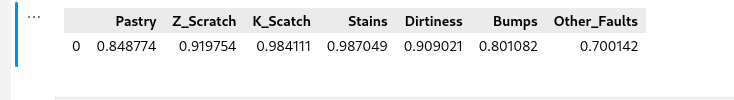

In [123]:
model.eval()
with torch.no_grad():
    output=model(torch.as_tensor(std_scaler.transform(test_data.iloc[:,1:]),dtype=torch.float32)).detach().cpu().numpy()

In [129]:
submission=pd.read_csv('sample_submission.csv')
for i,col in enumerate(y_train.columns.tolist()):
    submission[col]=output[:,i]


In [130]:
submission.head()

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.399054,0.000547,1.059117e-05,1.722303e-09,0.006987,0.124960,0.327392
1,19220,0.169128,0.008424,1.432169e-03,1.205217e-04,0.145671,0.135352,0.482047
2,19221,0.010120,0.016049,7.422062e-02,1.337355e-03,0.013266,0.230615,0.554111
3,19222,0.123622,0.000854,6.769546e-05,8.816560e-05,0.005850,0.554447,0.280739
4,19223,0.001389,0.000157,4.205092e-08,1.323960e-09,0.000057,0.800471,0.149476


In [131]:
submission.to_csv("torch_baseline_submission.csv",index=False)

***Code moved to kaggle for experimenting***